<a href="https://colab.research.google.com/github/HemiaoZhang/CEE316Project/blob/main/2_cnn_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Mar  9 16:12:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


## Data Loading

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Colab Notebooks/CEE316
!pwd

path = '/content/gdrive/MyDrive/Colab Notebooks/CEE316/Project/Data/Berea_2d25um_binary.raw'
img3d = np.fromfile(path, dtype=np.uint8)
imgSize = (1000,1000,1000)
img3d = img3d.reshape(imgSize)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/CEE316
/content/gdrive/MyDrive/Colab Notebooks/CEE316


In [5]:
class CustomImageDataset(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.label = torch.mean(data, (1,2,3), True).view(-1)
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image = self.data[idx]
    porosity = self.label[idx]

    if self.transform!=None:
      image = self.transform(image)
    return (image, porosity)

In [6]:
# 1,000 = 16 * 62 + 8
# 500x2.25micron per side
train_data = CustomImageDataset(torch.tensor( np.vstack( ( img3d[0:1000:4,:500,:500].reshape(250,1,500,500),
                                                           img3d[1:1000:4,:500,-500:].reshape(250,1,500,500),
                                                           img3d[2:1000:4,-500:,:500].reshape(250,1,500,500),
                                                           img3d[3:1000:4,-500:,-500:].reshape(250,1,500,500) ) ), \
                                              dtype=torch.float32) )
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
len(train_data)

test_data = CustomImageDataset(torch.tensor(img3d[2:400:4,:500,:500].reshape(100,1,500,500), dtype=torch.float32))
test_loader = DataLoader(dataset=test_data, batch_size=1)

total number of training data: 1000
total number of testing data: 100
min of data: 0.0
max of data: 1.0
length of the cubic area: 1125.0 microns


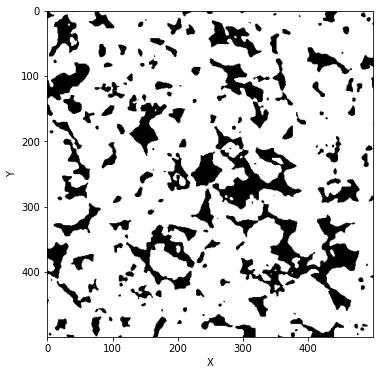

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel("X")
ax.set_ylabel("Y")
print(f'total number of training data: {len(train_data)}')
print(f'total number of testing data: {len(test_data)}')
print(f'min of data: {torch.min(train_data.data[0])}')
print(f'max of data: {torch.max(train_data.data[0])}')
print(f'length of the cubic area: {train_data.data[0].shape[1]*2.25} microns')
ax.imshow(train_data.data[60].reshape(500,500).detach().numpy(), cmap='gray')

## CNN Architecture

[sizing for hyperparameters](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)
$$
O = \frac{I - F + P_{\text{start}} + P_{\text{end}}}{S} + 1
$$

torch.nn.**Conv2d**(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

For rectangular image, with floor function

H(out)=⌊ [H(in)+2×padding[0]−dilation[0]×(kernel_size[0]−1)−1] / stride[0] + 1 ⌋

W(out)=⌊ [W(in)+2×padding[1]−dilation[1]×(kernel_size[1]−1)−1] / stride[1] + 1 ⌋

torch.nn.**ConvTranspose2d**(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)

For rectangular image,

H(out)=(H(in)−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1

W(out)=(W(in)−1)×stride[1]−2×padding[1]+dilation[1]×(kernel_size[1]−1)+output_padding[1]+1

In [8]:
# define encoder
class Encoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=8, latent_dim=5):
    super().__init__()

    self.net = nn.Sequential(
        # floor((500-3+1+1)/2 + 1) = 250
        nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1), # -> N, 16, 125, 125
        nn.ReLU(),
        # floor((250-3+1+1)/2 + 1) = 125
        nn.Conv2d(out_channels, 2*out_channels, 3, stride=2, padding=1), # -> N, 32, 31, 31
        nn.ReLU(),
        # floor((125-3+1+1)/2 + 1) = 63
        nn.Conv2d(2*out_channels, 4*out_channels, 3, stride=2, padding=1), # -> N, 64, 16, 16
        nn.ReLU(),
        # floor((63-3+1+1)/2 + 1) = 32
        nn.Conv2d(4*out_channels, 2*out_channels, 3, stride=2, padding=1), # -> N, 32, 8, 8
        nn.ReLU(),
        # floor((32-3+1+1)/2 + 1) = 16
        nn.Conv2d(2*out_channels, out_channels, 3, stride=2, padding=1), # -> N, 16, 4, 4
        nn.ReLU(),
        # floor((16-3+1+1)/2 + 1) = 8
        nn.Conv2d(out_channels, out_channels, 3, stride=2, padding=1), # -> N, 16, 4, 4
        nn.ReLU(),
        # floor((8-8)/1 + 1) = 1
        nn.Conv2d(out_channels, out_channels, 8), # -> N, 16, 1, 1
        nn.ReLU(),
        nn.Flatten(),  # -> N, 16
        nn.Linear(out_channels, latent_dim), # -> N, 5
        nn.ReLU()
    )

  def forward(self, x):
    output = self.net(x)
    return output

# define decoder
class Decoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=8, latent_dim=5):
    super().__init__()

    self.out_channels = out_channels

    self.linear = nn.Sequential(
        nn.Linear(latent_dim, out_channels), # -> N, 16
        nn.ReLU()
    )

    self.conv = nn.Sequential(
        # (1-1)*1 + (8-1) + 1 = 8
        nn.ConvTranspose2d(out_channels, out_channels, 8), # -> N, 16, 4, 4
        nn.ReLU(),
        # (8-1)*2-1-1 + (3-1) + 1 + 1 = 16
        nn.ConvTranspose2d(out_channels, out_channels, 3, stride=2, padding=1, output_padding=1), # -> N, 32, 8, 8
        nn.ReLU(),
        # (16-1)*2-1-1 + (3-1) + 1 + 1 = 32
        nn.ConvTranspose2d(out_channels, 2*out_channels, 3, stride=2, padding=1, output_padding=1), # -> N, 64, 16, 16
        nn.ReLU(),
        # (32-1)*2-1-1 + (3-1) + 1 = 63
        nn.ConvTranspose2d(2*out_channels, 4*out_channels, 3, stride=2, padding=1), # -> N, 32, 31, 31
        nn.ReLU(),
        # (63-1)*2-1-1 + (3-1) + 1 = 125
        nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, stride=2, padding=1), # -> N, 16, 100, 100
        nn.ReLU(),
        # (125-1)*2-1-1 + (3-1) + 1 + 1 = 250
        nn.ConvTranspose2d(2*out_channels, out_channels, 3, stride=2, padding=1, output_padding=1), # -> N, 16, 100, 100
        nn.ReLU(),
        # (125-1)*2-1-1 + (3-1) + 1 + 1 = 500
        nn.ConvTranspose2d(out_channels, in_channels, 3, stride=2, padding=1, output_padding=1), # -> N, 1, 500, 500
        nn.Sigmoid() # since min=0. max=1.
    )

  def forward(self, x):
    output = self.linear(x)
    output = output.view(-1, self.out_channels, 1, 1)
    output = self.conv(output)
    return output

# define autoencoder
class Autoencoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.encoder.to(device)

    self.decoder = decoder
    self.decoder.to(device)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

When lantent_dim is 2 or 4, the resulted embedding collapse into a point.

In [9]:
out_channels = 16
latent_dim = 8
model = Autoencoder(Encoder(out_channels=out_channels, latent_dim=latent_dim), \
                    Decoder(out_channels=out_channels, latent_dim=latent_dim))
model

Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(16, 16, kernel_size=(8, 8), stride=(1, 1))
      (13): ReLU()
      (14): Flatten(start_dim=1, end_dim=-1)
      (15): Linear(in_features=16, out_features=8, bias=True)
      (16): ReLU()
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): ReLU()
    )
    (conv): Sequentia

## Training

In [10]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.85)
num_epochs = 5000
best_loss = np.inf
best_states = None
loss_history = []

for epoch in range(num_epochs):
  model.train()
  train_losses = []
  for batch, label in train_loader:
    optimizer.zero_grad()
    
    img = batch.to(device) # img.shape = torch.Size([batch_size, 1, 200, 200])
    recon = model(img)
    loss = loss_fn(recon, img)
    
    loss.backward()
    optimizer.step()

    train_losses.append( loss.detach().item() )

  epoch_loss = np.mean(train_losses)
  if epoch_loss < best_loss:
    best_loss = np.copy(epoch_loss)
    best_states = copy.deepcopy( model.state_dict() )
  # record loss history
  if (epoch+1) % 250 == 0: print("epoch {:4d}, training loss = {:1.5e}".format(epoch+1, epoch_loss))
  loss_history.append(epoch_loss)
  # adjust the learning rate
  sch.step()

epoch  250, training loss = 1.66446e-01
epoch  500, training loss = 1.64770e-01
epoch  750, training loss = 1.64140e-01
epoch 1000, training loss = 1.63864e-01
epoch 1250, training loss = 1.63739e-01
epoch 1500, training loss = 1.63616e-01
epoch 1750, training loss = 1.63657e-01
epoch 2000, training loss = 1.63628e-01
epoch 2250, training loss = 1.63620e-01
epoch 2500, training loss = 1.63630e-01
epoch 2750, training loss = 1.63615e-01
epoch 3000, training loss = 1.63628e-01
epoch 3250, training loss = 1.63647e-01
epoch 3500, training loss = 1.63614e-01
epoch 3750, training loss = 1.63665e-01
epoch 4000, training loss = 1.63624e-01
epoch 4250, training loss = 1.63665e-01
epoch 4500, training loss = 1.63616e-01
epoch 4750, training loss = 1.63682e-01
epoch 5000, training loss = 1.63652e-01


In [11]:
# save the best state in the trained model
model.load_state_dict(best_states)
nlayers = 1
count = 0
for name, param in model.named_parameters():
    if param.requires_grad and count < nlayers:
        print(name, param.data)
        count += 1

path = '/content/gdrive/MyDrive/Colab Notebooks/CEE316/Project/Data/cnn_model.pth'
torch.save(best_states, path)

encoder.net.0.weight tensor([[[[ 1.2089e-01, -1.0551e-01, -2.1302e-01],
          [ 2.8027e-01,  1.9651e-01,  5.4703e-02],
          [ 2.1875e-01,  1.9370e-01,  2.1761e-01]]],


        [[[-9.3908e-02, -6.5132e-03,  2.1134e-01],
          [ 3.1725e-03,  6.7020e-02,  1.6581e-01],
          [ 1.8346e-02, -7.9739e-02, -7.6708e-02]]],


        [[[-7.0483e-41,  2.8222e-40,  1.7541e-40],
          [-1.9406e-40, -8.8311e-41,  1.6776e-40],
          [ 8.7088e-41, -5.6821e-40, -2.8152e-40]]],


        [[[-8.3767e-02, -1.0999e-01,  7.4477e-02],
          [ 2.1064e-02,  2.9733e-01, -5.4510e-02],
          [ 1.7875e-01, -2.1555e-01,  2.6569e-01]]],


        [[[-1.3350e-01, -7.8245e-03, -9.2262e-02],
          [-7.1878e-02,  4.1683e-02,  2.6797e-02],
          [-5.5411e-02,  3.8033e-02,  1.8243e-02]]],


        [[[-1.9338e-02,  3.0721e-03,  5.0075e-02],
          [ 8.7207e-03,  3.8263e-04,  1.4254e-02],
          [-1.1590e-02,  5.3378e-02, -8.8787e-04]]],


        [[[-5.1025e-02, -7.1935e-02, 

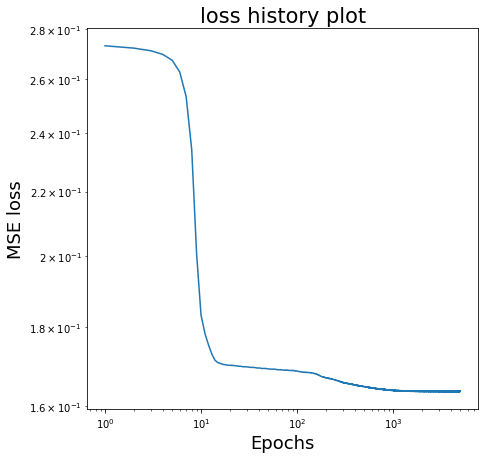

In [12]:
# plot loss history
plt.figure(0,figsize=(7,7))
plt.loglog(np.arange(1,num_epochs+1), loss_history)
plt.title('loss history plot', fontsize=21)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('MSE loss', fontsize=18)
plt.show()

In [10]:
# reload the trained model
out_channels = 16
latent_dim = 8
model = Autoencoder(Encoder(out_channels=out_channels, latent_dim=latent_dim), \
                    Decoder(out_channels=out_channels, latent_dim=latent_dim))
model.eval()

path = '/content/gdrive/MyDrive/Colab Notebooks/CEE316/Project/Data/cnn_model.pth'
model.load_state_dict(torch.load(path))

nlayers = 1
count = 0
for name, param in model.named_parameters():
    if param.requires_grad and count < nlayers:
        print(name, param.data)
        count += 1

encoder.net.0.weight tensor([[[[ 1.2089e-01, -1.0551e-01, -2.1302e-01],
          [ 2.8027e-01,  1.9651e-01,  5.4703e-02],
          [ 2.1875e-01,  1.9370e-01,  2.1761e-01]]],


        [[[-9.3908e-02, -6.5132e-03,  2.1134e-01],
          [ 3.1725e-03,  6.7020e-02,  1.6581e-01],
          [ 1.8346e-02, -7.9739e-02, -7.6708e-02]]],


        [[[-7.0483e-41,  2.8222e-40,  1.7541e-40],
          [-1.9406e-40, -8.8311e-41,  1.6776e-40],
          [ 8.7088e-41, -5.6821e-40, -2.8152e-40]]],


        [[[-8.3767e-02, -1.0999e-01,  7.4477e-02],
          [ 2.1064e-02,  2.9733e-01, -5.4510e-02],
          [ 1.7875e-01, -2.1555e-01,  2.6569e-01]]],


        [[[-1.3350e-01, -7.8245e-03, -9.2262e-02],
          [-7.1878e-02,  4.1683e-02,  2.6797e-02],
          [-5.5411e-02,  3.8033e-02,  1.8243e-02]]],


        [[[-1.9338e-02,  3.0721e-03,  5.0075e-02],
          [ 8.7207e-03,  3.8263e-04,  1.4254e-02],
          [-1.1590e-02,  5.3378e-02, -8.8787e-04]]],


        [[[-5.1025e-02, -7.1935e-02, 

## Embedding

In [36]:
def binarization(img, threshold=0.5, lower=0, upper=1):
  '''
  Take in an image (numpy.array) with pixel/voxel values in [0,1] and,
  convert to a binary image of {0, 1}
  '''
  return np.where(img<=threshold, lower, upper)

def plot_latent_2d(autoencoder, loader, z1=0, z2=1):
  '''
  plot z1-th and z2-th feature in the encoded feature vector z
  '''
  plt.figure(figsize=(6,6))
  plt.xlabel(f'X=z{z1}')
  plt.ylabel(f'Y=z{z2}')
  min = torch.min(loader.dataset.label)
  max = torch.max(loader.dataset.label)
  for batch, label in loader:
    z = autoencoder.encoder(batch.to(device))
    z = z.cpu().detach().numpy()  
    plt.scatter(z[:, z1], z[:, z2], c=label, cmap='viridis')
    plt.clim(min, max) # for porosity
  plt.colorbar().set_label('Porosity',rotation=270)

def plot_latent_boxwhisker(autoencoder, loader):
  '''
  plot the distribution of each embedded features, and
  return a vector of mean of each feature
  '''
  z_array = np.array([])
  for batch, label in loader:
    z = autoencoder.encoder(batch.to(device))
    z = z.cpu().detach().numpy() # -> N, latent_dim
    if z_array.shape[0]==0:
      z_array = z
    else:
      z_array = np.vstack((z_array, z))

  plt.figure(figsize=(12,6))
  print(f'number of training samples: {z_array.shape[0]}')
  print(f'number of features: {z_array.shape[1]}')
  plt.boxplot(z_array)
  return np.mean(z_array, axis=0)

def plot_reconstructed(autoencoder, z, z1=0, z2=1, r1=(5, 20), r2=(5, 20), n=5):
  '''
  generate image from given encoded feature vector z with
  altering feature z1 and z2
  '''
  w = 500 # pixel width
  img = np.zeros((n*w, n*w))
  for i, y in enumerate(np.linspace(*r2, n)):
    for j, x in enumerate(np.linspace(*r1, n)):
      z[0] = x
      z[1] = y
      z = torch.tensor(z, dtype=torch.float32).to(device)
      x_hat = autoencoder.decoder(z)
      x_hat = x_hat.reshape(500, 500).cpu().detach().numpy()
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
  plt.figure(0, figsize=(12,12))
  plt.xlabel(f'X=z{z1}')
  plt.ylabel(f'Y=z{z2}')
  plt.gray()
  plt.imshow(img, extent=[*r1, *r2], vmin=0., vmax=1.)

  plt.figure(1, figsize=(12,12))
  plt.xlabel(f'X=z{z1}')
  plt.ylabel(f'Y=z{z2}')
  plt.gray()
  plt.imshow( binarization(img), extent=[*r1, *r2], vmin=0., vmax=1.)  

number of training samples: 1000
number of features: 8


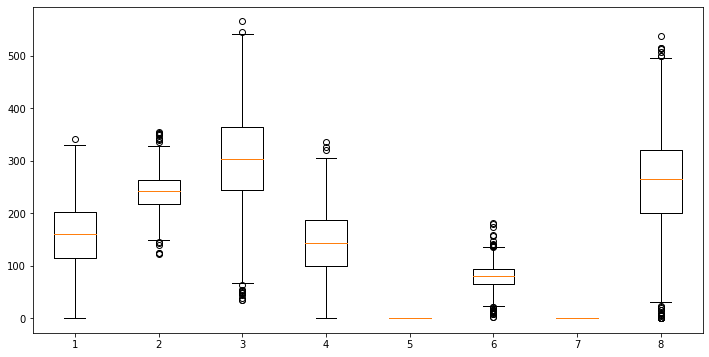

In [12]:
mean_embedding = plot_latent_boxwhisker(model, train_loader)

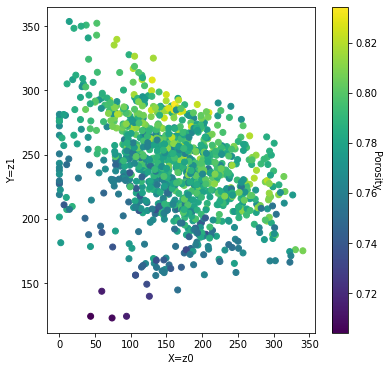

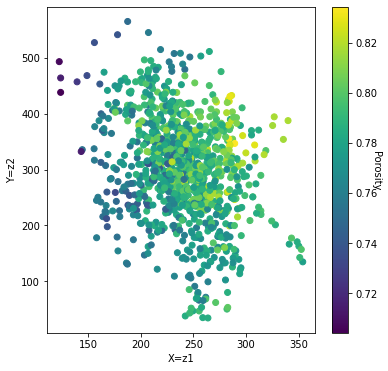

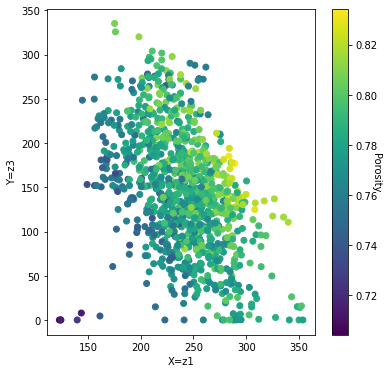

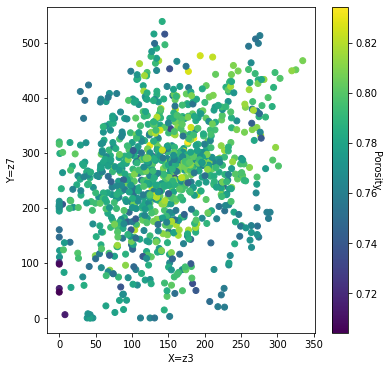

In [26]:
plot_latent_2d(model, train_loader, z1=0, z2=1)
plot_latent_2d(model, train_loader, z1=1, z2=2)
plot_latent_2d(model, train_loader, z1=1, z2=3) 
plot_latent_2d(model, train_loader, z1=3, z2=7)

<ipython-input-36-4279ac70a753>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, dtype=torch.float32).to(device)


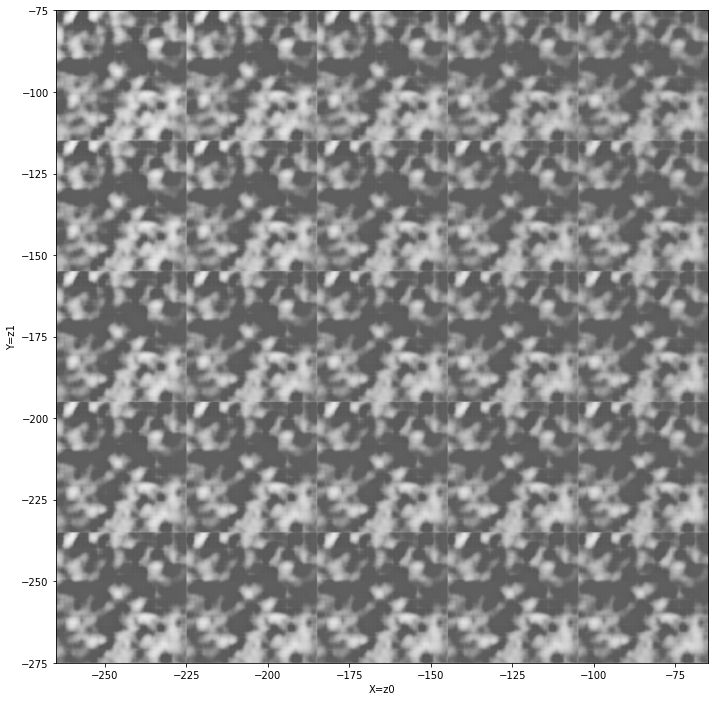

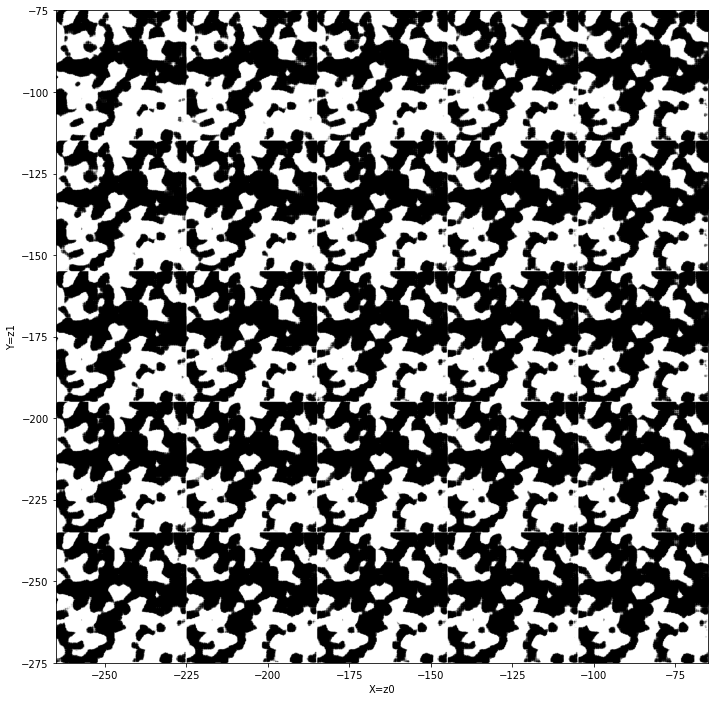

In [37]:
embedding = model.encoder(train_loader.dataset.data[0].view(-1,1,500,500).to(device))
embedding = embedding.cpu().detach().numpy() 

s = 100 # span
plot_reconstructed(model, mean_embedding, z1=0, z2=1, r1=(int(mean_embedding[0])-s, int(mean_embedding[0])+s), r2=(int(mean_embedding[1])-s, int(mean_embedding[1])+s))
#plot_reconstructed(model, mean_embedding, z1=0, z2=2, r1=(100, 125), r2=(30, 55))
#plot_reconstructed(model, mean_embedding, z1=0, z2=3, r1=(100, 125), r2=(90, 115))
#plot_reconstructed(model, mean_embedding, z1=2, z2=3, r1=(10, 30), r2=(10, 30))

## Testing

In [15]:
test_img = []
test_recon = []
for batch, label in test_loader: # one per batch
  img = batch.to(device)  
  recon = model(img)
  test_img.append( img.cpu().detach().numpy() )
  test_recon.append( recon.cpu().detach().numpy() )

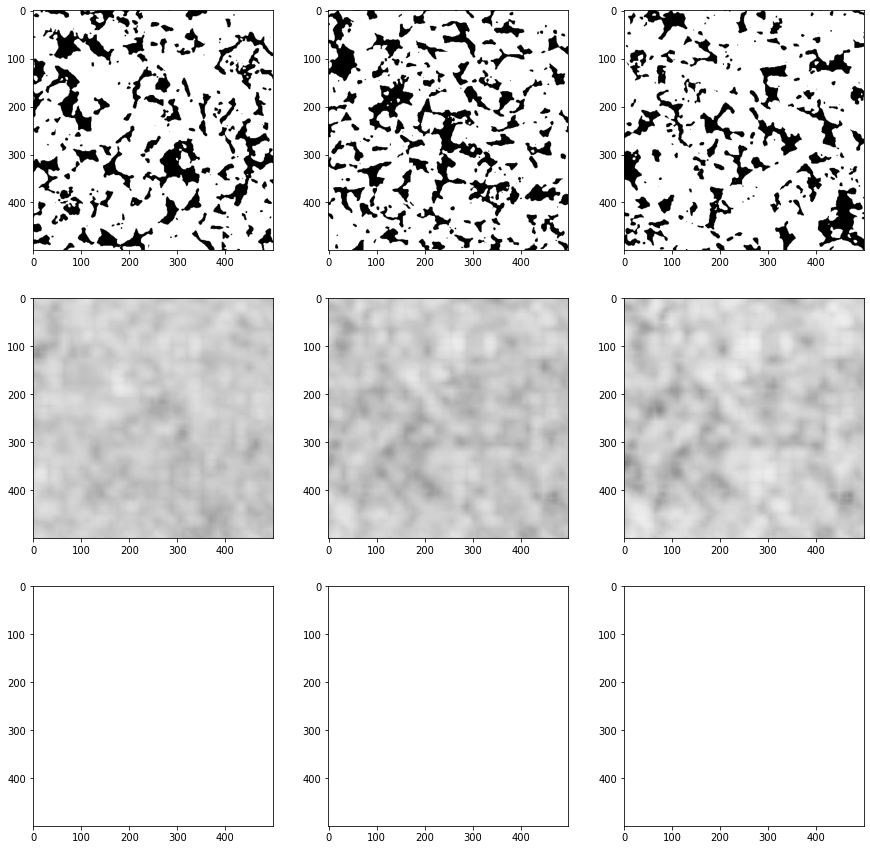

In [44]:
# randonly select 10 testing cases
n2show = 3
idx = np.random.randint(0, len(test_data), n2show)
#idx = range(10)
plt.figure(figsize=(15,15))
plt.gray()
for k in range(n2show):
  plt.subplot(3,n2show,k+1) # first line
  plt.imshow(test_img[idx[k]].reshape(500, 500), vmin=0., vmax=1.)

  plt.subplot(3,n2show,n2show+k+1) # second line
  plt.imshow( test_recon[idx[k]].reshape(500, 500), vmin=0., vmax=1. )
  #plt.clim(0., 1.)
  
  plt.subplot(3,n2show,2*n2show+k+1) # third line
  plt.imshow( binarization( test_recon[idx[k]].reshape(500, 500) ), vmin=0., vmax=1. )

In [ ]:
# end runtime
from google.colab import runtime

In [ ]:
runtime.unassign()